In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [37]:
X_train = train.drop(labels=["label"],axis=1)

In [38]:
train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [39]:
y_train=train["label"]

In [40]:
del train

In [41]:
#train.head()
#SEe the file is deleted 

In [42]:
import warnings
warnings.filterwarnings('ignore')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

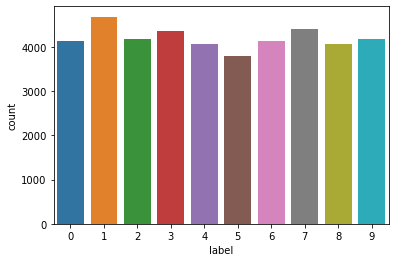

In [43]:
g=sns.countplot(y_train)
y_train.value_counts()
#we can see the data is balanced as it should be 

In [44]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [45]:
#The any() function returns True if any item in an iterable are true, otherwise it returns False.
#If the iterable object is empty, the any() function will return False
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [46]:
#we can see that there is no null values so we can move ahead

# Normalisation

We perform a grayscale normalization to reduce the effect of illumination's differences.
Moreover the CNN converg faster on [0..1] data than on [0..255].

In [47]:
X_train = X_train/255.0
test = test/255.0

# Reshape Images 
 Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

In [48]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)



Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices

In [49]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train,num_classes=10)

In [50]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2)

In [53]:
#we have used 90% of the data of train for training the model and 10% to validate our model

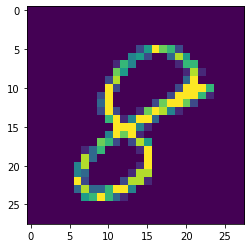

In [54]:
g=plt.imshow(X_train[0][:,:,0])
g

In [ ]:
from keras.models import Sequential
from model.layers import Dense,Dropout,MaxPool2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator

# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
model=Sequential()
model.add(Conv2D(filter=32,kernal_size=(5,5),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filter=32,kernal_size=(5,5),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filter=64,kernal_size=(5,5),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filter=64,kernal_size=(5,5),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))


In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [ ]:
 #With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)